In [ ]:
import pandas as pd

df = pd.read_csv("Mall_Customers.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
numeric_features = df.select_dtypes(include=["int64", "float64"])

# حذف ID چون ویژگی مفهومی نیست
numeric_features = numeric_features.drop(columns=["CustomerID"])

numeric_features.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

print("Scaled data shape:", X_scaled.shape)

Scaled data shape: (200, 3)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=83)
X_pca = pca.fit_transform(X_scaled)

print("PCA shape:", X_pca.shape)

PCA shape: (200, 2)


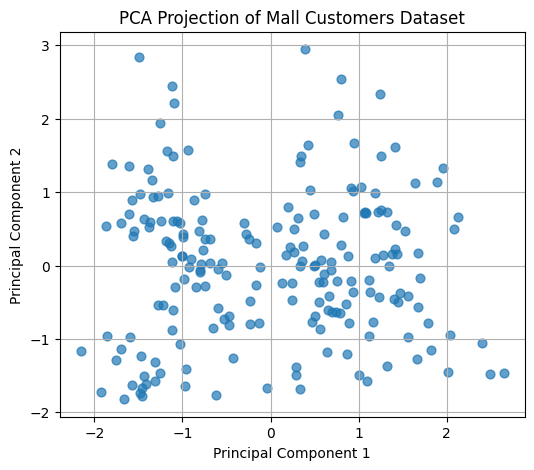

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=40, alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Mall Customers Dataset")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []
K_values = range(2, 11)

for k in K_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=83,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

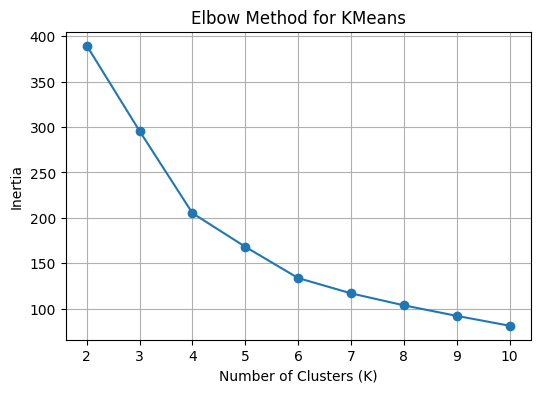

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(K_values, inertias, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.grid(True)
plt.show()

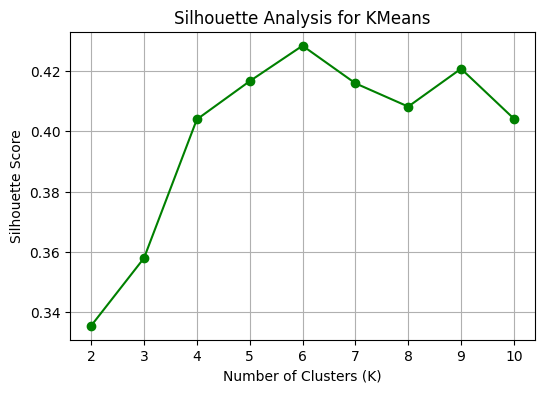

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(K_values, silhouettes, marker='o', color='green')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for KMeans")
plt.grid(True)
plt.show()

In [ ]:
for k, inertia, sil in zip(K_values, inertias, silhouettes):
    print(f"K={k:2d} | Inertia={inertia:.2f} | Silhouette={sil:.4f}")

K= 2 | Inertia=389.39 | Silhouette=0.3355
K= 3 | Inertia=295.46 | Silhouette=0.3579
K= 4 | Inertia=205.23 | Silhouette=0.4040
K= 5 | Inertia=168.25 | Silhouette=0.4166
K= 6 | Inertia=133.87 | Silhouette=0.4284
K= 7 | Inertia=117.06 | Silhouette=0.4159
K= 8 | Inertia=103.87 | Silhouette=0.4082
K= 9 | Inertia=92.29 | Silhouette=0.4208
K=10 | Inertia=81.44 | Silhouette=0.4042


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

linkages = ["single", "complete", "average", "ward"]
agg_silhouettes = {}

for linkage in linkages:
    model = AgglomerativeClustering(
        n_clusters=6,
        linkage=linkage
    )
    labels = model.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    agg_silhouettes[linkage] = sil

In [ ]:
for linkage, sil in agg_silhouettes.items():
    print(f"Linkage: {linkage:8s} | Silhouette Score: {sil:.4f}")

Linkage: single   | Silhouette Score: -0.0428
Linkage: complete | Silhouette Score: 0.3746
Linkage: average  | Silhouette Score: 0.3896
Linkage: ward     | Silhouette Score: 0.4201


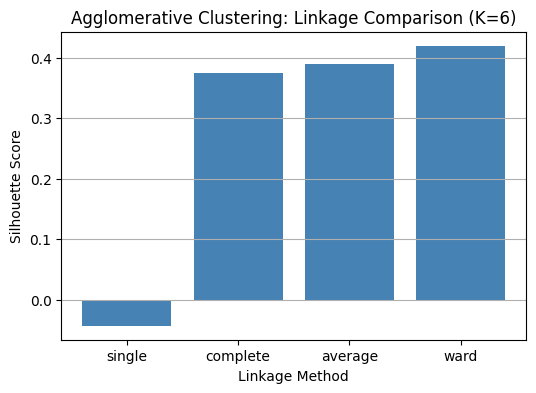

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(agg_silhouettes.keys(), agg_silhouettes.values(), color="steelblue")
plt.xlabel("Linkage Method")
plt.ylabel("Silhouette Score")
plt.title("Agglomerative Clustering: Linkage Comparison (K=6)")
plt.grid(axis="y")
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

eps_values = [0.2, 0.4, 0.6, 0.8, 1.0]
min_samples_values = [3, 5, 10]

dbscan_results = []

for eps in eps_values:
    for min_s in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_s)
        labels = dbscan.fit_predict(X_scaled)

        # تعداد خوشه‌ها (بدون نویز)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # محاسبه silhouette فقط روی نقاط غیر نویز
        if n_clusters > 1:
            mask = labels != -1
            sil = silhouette_score(X_scaled[mask], labels[mask])
        else:
            sil = None

        dbscan_results.append({
            "eps": eps,
            "min_samples": min_s,
            "clusters": n_clusters,
            "noise_points": n_noise,
            "silhouette": sil
        })

In [ ]:
for res in dbscan_results:
    print(
        f"eps={res['eps']:<3} | min_samples={res['min_samples']:<2} | "
        f"clusters={res['clusters']:<2} | noise={res['noise_points']:<3} | "
        f"silhouette={res['silhouette']}"
    )

eps=0.2 | min_samples=3  | clusters=11 | noise=161 | silhouette=0.6458799579604083
eps=0.2 | min_samples=5  | clusters=1  | noise=195 | silhouette=None
eps=0.2 | min_samples=10 | clusters=0  | noise=200 | silhouette=None
eps=0.4 | min_samples=3  | clusters=10 | noise=59  | silhouette=0.44257547291650223
eps=0.4 | min_samples=5  | clusters=6  | noise=98  | silhouette=0.5190232911585904
eps=0.4 | min_samples=10 | clusters=2  | noise=170 | silhouette=0.766072623663944
eps=0.6 | min_samples=3  | clusters=3  | noise=14  | silhouette=0.21488074633076337
eps=0.6 | min_samples=5  | clusters=2  | noise=28  | silhouette=0.2730470532970596
eps=0.6 | min_samples=10 | clusters=4  | noise=66  | silhouette=0.5295886734911655
eps=0.8 | min_samples=3  | clusters=1  | noise=3   | silhouette=None
eps=0.8 | min_samples=5  | clusters=1  | noise=6   | silhouette=None
eps=0.8 | min_samples=10 | clusters=1  | noise=23  | silhouette=None
eps=1.0 | min_samples=3  | clusters=1  | noise=1   | silhouette=None
eps=

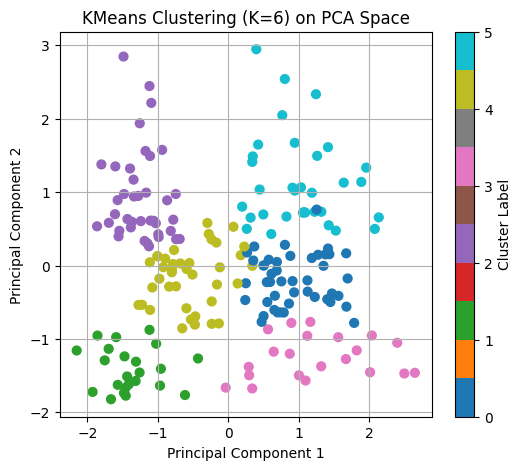

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=83, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans_labels, cmap="tab10", s=40
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans Clustering (K=6) on PCA Space")
plt.colorbar(label="Cluster Label")
plt.grid(True)
plt.show()

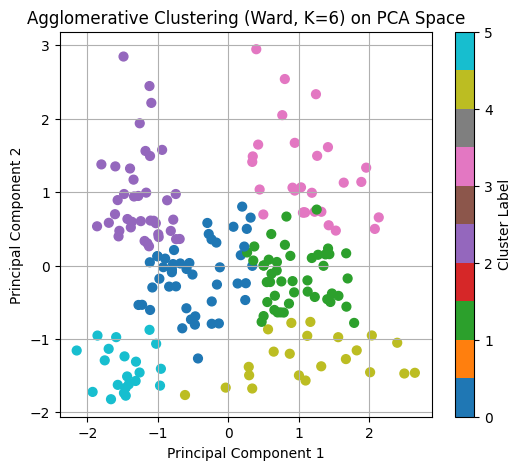

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(
    n_clusters=6,
    linkage="ward"
)
agg_labels = agg.fit_predict(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=agg_labels, cmap="tab10", s=40
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Agglomerative Clustering (Ward, K=6) on PCA Space")
plt.colorbar(label="Cluster Label")
plt.grid(True)
plt.show()

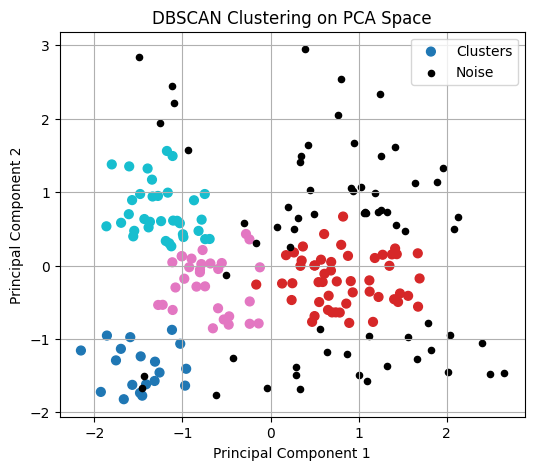

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

dbscan = DBSCAN(eps=0.6, min_samples=10)
db_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(6,5))

# نقاط غیر نویز
mask = db_labels != -1
plt.scatter(
    X_pca[mask, 0], X_pca[mask, 1],
    c=db_labels[mask], cmap="tab10", s=40, label="Clusters"
)

# نقاط نویز
plt.scatter(
    X_pca[~mask, 0], X_pca[~mask, 1],
    c="black", s=20, label="Noise"
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("DBSCAN Clustering on PCA Space")
plt.legend()
plt.grid(True)
plt.show()